# la magie de FLYOD- STEINBERG

## import des librairies

si il t'en manque, voici les pip install :

scikit-image (skimage)
```Python
# Update pip
python -m pip install -U pip
# Install scikit-image
python -m pip install -U scikit-image
```

pillow (PIL)
```Python
python3 -m pip install --upgrade pip
python3 -m pip install --upgrade Pillow
```

numpy
```Python
pip install numpy
```

matplotlib
```Python
python -m pip install -U pip
python -m pip install -U matplotlib
```

In [1]:
from PIL import Image

import skimage
from skimage import io, color
from skimage.util import crop
from skimage.transform import resize

import numpy as np
import matplotlib.pyplot as plt

la cellule suivante est pas spécialement importante, elle me sert juste à calculer des coordonnées dans l'image pour cropper en format carré.

In [2]:
def squareCropCoordinate(image):
    bbox = (0, 0, image.shape[0], image.shape[1])

    # is the image allready square ?
    if bbox[2] == bbox[3]:
        return bbox

    # is the image in landscape mode ?
    isLandscape = bbox[2] > bbox[3]

    if isLandscape:
        deltaX = int((bbox[2] - bbox[3]) / 2)
        return ((deltaX, deltaX), (0, 0), (0, 0))
    else:
        deltaY = int((bbox[3] - bbox[2]) / 2)
        return ((0, 0), (deltaY, deltaY), (0, 0))

### la magie opère ici!

la fonction est capable de calculer un résultats en noir et blanc ou en couleur. c'est quasiment deux fois le même code.

le fonctionnement :
<ol>
<li> oldPixel la valeur du pixel actuel <li\>
<li> newPixel est la couleur de la palette la plus proche de oldPixel <li\>
<li> on remplace dans l'image l'ancien pixel par le nouveau <li\>
<li> on calcule une erreur de quantificiation en faisant la différence entre newPixel et oldPixel <li\>
<li> le génie est la : on propage cette erreur sur les pixels voisins. on remplace leur couleur par leur couleur PLUS l'erreur <li\>
<li> on recommance l'opération sur le pixel suivant. Celui ci est donc sa couleur plus l'erreur qui se propage <li\>
<ol\>

visuellement, l'erreur se propage suivant cette matrice :
$$\begin{bmatrix} 0 & 0 & 0 \\ 0 & * & \frac{7}{16} \\ \frac{3}{16} & \frac{5}{16} & \frac{1}{16} \end{bmatrix}$$

In [3]:
def floydSteinbergDither(array, palette, mode, colorBias=1):
    if mode == 'GRAY':
        output = np.copy(array)

        for y in np.arange(0, output.shape[1] - 1, 1):
            for x in np.arange(0, output.shape[0] - 1, 1):

                oldPixel = output[x, y]
                newPixel = findClosest(oldPixel, palette, 'GRAY')
                output[x, y] = newPixel

                quant_error = oldPixel - newPixel
                output[x + 1, y] = output[x + 1, y] + quant_error * 7 / 16
                output[x - 1, y + 1] = output[x - 1, y + 1] + quant_error * 3 / 16
                output[x, y + 1] = output[x, y + 1] + quant_error * 5 / 16
                output[x + 1, y + 1] = output[x + 1, y + 1] + quant_error * 1 / 16

        return output

    elif mode == 'RGB' or mode == 'LAB':
        output = np.copy(array)

        for y in np.arange(0, output.shape[1] - 1, 1):
            for x in np.arange(0, output.shape[0] - 1, 1):

                oldPixel = np.copy(output[x, y, :])
                newPixel = findClosest(oldPixel, palette, mode, colorBias)
                output[x, y, :] = newPixel

                quant_error = oldPixel - newPixel

                output[x + 1, y, :] = output[x + 1, y, :] + quant_error * 7 / 16
                output[x - 1, y + 1, :] = output[x - 1, y + 1, :] + quant_error * 3 / 16
                output[x, y + 1, :] = output[x, y + 1, :] + quant_error * 5 / 16
                output[x + 1, y + 1, :] = output[x + 1, y + 1, :] + quant_error * 1 / 16

        return output

cette cellule déclare la fonction utilisée dans ```floydSteinbergDither()``` pour trouver dans la palette la couleur la plus proche de la valeur.

```colorbias``` ne sert qu'en LAB et permet simplement de saturer les couleurs de la valeur avant de chercher la couleur correspondante.

In [6]:
def findClosest(value, palette, mode, colorBias=1):
    if mode == 'GRAY':
        return palette[np.argmin(abs(palette - value))]

    elif mode == 'LAB' or mode == 'RGB':
        x = palette[0, :, 0]
        y = palette[0, :, 1]
        z = palette[0, :, 2]

        dx = x - value[0]
        dy = y - value[1] * colorBias
        dz = z - value[2] * colorBias

        dist = np.sqrt(dx**2 + dy**2 + dz**2)

        return palette[0, np.argmin(dist), :]


la celulle suivante me permet simplement de créer une pallette de couleur en spécifiant la valeur max et le nombre de valeur possible par couche.

In [4]:
def createPalette(nbStep, vmax, mode):
    c = np.linspace(0, vmax, nbStep)
    if mode == 'GRAY':
        return c
    elif mode == 'RGB':
        X, Y, Z = np.meshgrid(c, c, c)
        X = X.flatten()
        Y = Y.flatten()
        Z = Z.flatten()

        output = np.zeros((1, len(X), 3))
        output[0, :, 0] = X
        output[0, :, 1] = Y
        output[0, :, 2] = Z

        return output

    elif mode == 'LAB':
        X, Y, Z = np.meshgrid(np.linspace(0, vmax, nbStep),
                              np.linspace(-(vmax/2), vmax/2, nbStep),
                              np.linspace(-(vmax/2), vmax/2, nbStep))
        X = X.flatten()
        Y = Y.flatten()
        Z = Z.flatten()

        output = np.zeros((1, len(X), 3))
        output[0, :, 0] = X
        output[0, :, 1] = Y
        output[0, :, 2] = Z

        return output

celle cellule déclare simplement une fonction qui renvoit la pallette de __[PICO-8](https://www.lexaloffle.com/pico-8.php)__ soit en RGB, soit en LAB.

In [5]:
def pico8_Palette(mode):
    palette = np.array([[[0, 0, 0],
                        [29, 43, 83],
                        [0, 135, 81],
                        [171, 82, 54],
                        [95, 87, 79],
                        [194, 195, 199],
                        [255, 241, 232],
                        [255, 0, 77],
                        [255, 163, 0],
                        [255, 236, 39],
                        [0, 228, 54],
                        [41, 173, 255],
                        [131, 118, 156],
                        [255, 119, 168],
                        [255, 204, 170]]])/255
    if mode == 'RGB':
        return palette
        
    elif mode == 'LAB':
        return color.rgb2lab(palette)


allez, maintenant on met tout ça en route:
<ol>
<li> on ouvre la photo <li\>
<li> on crop en format carré <li\>
<li> on resize pour pas que ça prenne 30 plombes et demie <li\>
<li> on se crée une jolie palette <li\>
<li> et enfin on calcule la version issue de Floyd-Steinberg <li\>
<li> et on plot tout ça like a boss <li\>
<ol\>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


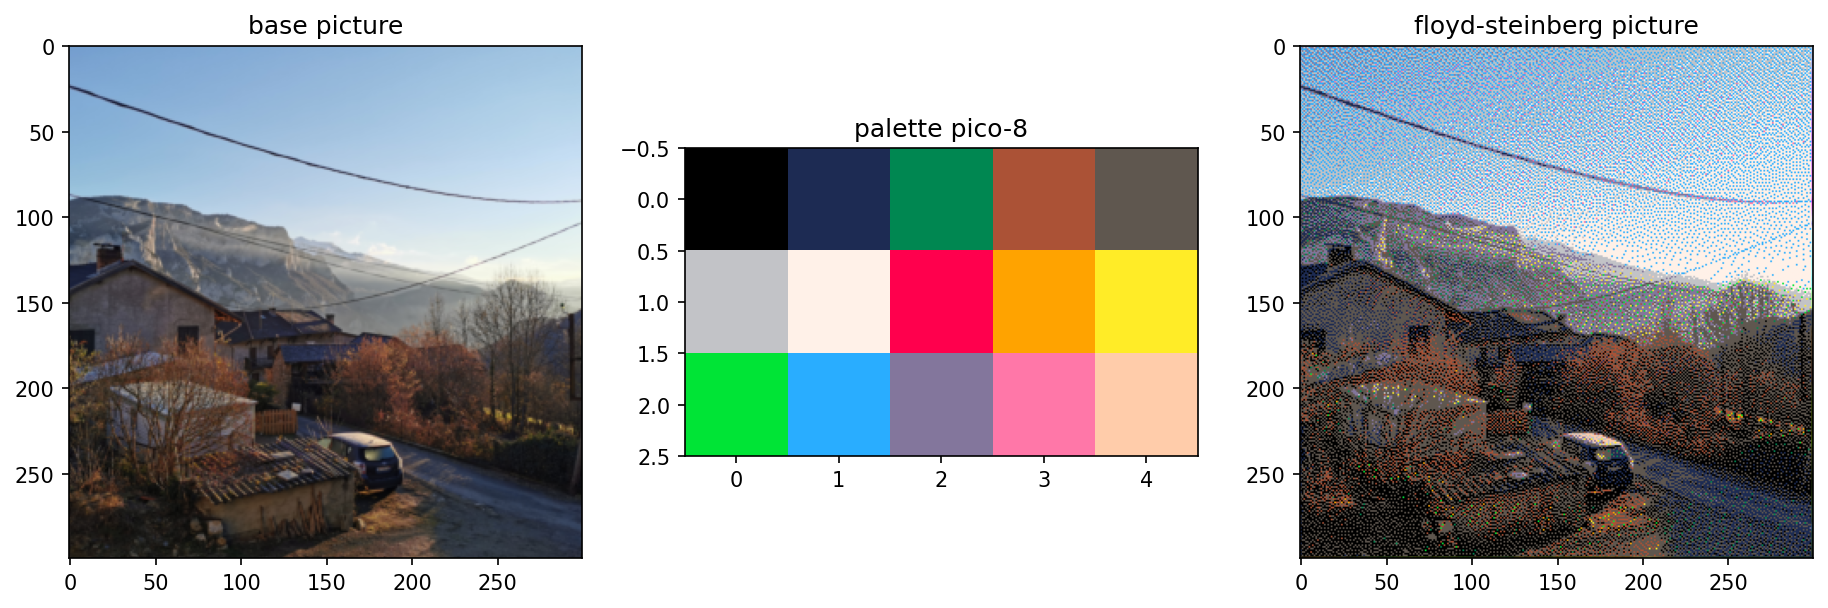

In [8]:
image = io.imread("photo.jpg")
image = crop(image, squareCropCoordinate(image))
image = resize(image, (300, 300, 3))

palette = pico8_Palette('RGB')

dithered_image_rgb = floydSteinbergDither(image, palette, 'RGB')


# plot everything

plt.figure(figsize=[15.0, 10.0], dpi=150)

plt.subplot(131)
plt.title("base picture")
plt.imshow(image)

plt.subplot(132)
plt.title("palette pico-8")
plt.imshow(np.reshape(palette, (3,-1,3)))

plt.subplot(133)
plt.title("floyd-steinberg picture")
plt.imshow(dithered_image_rgb)
